In [1]:
import tiktoken
import re

In [2]:
with open("the-verdict.txt", "r") as f:
    lines = f.read()

print(len(lines))

20479


In [3]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', lines)
print(preprocessed[:10])
preprocessed = [item for item in preprocessed if item.strip()]
print(len(preprocessed))

['I', ' ', 'HAD', ' ', 'always', ' ', 'thought', ' ', 'Jack', ' ']
4690


In [4]:
all_words = sorted(set(preprocessed))
print(all_words[-10:])
vocab_size = len(all_words)
print(vocab_size)
vocab = {token: idx for idx, token in enumerate(all_words)}
for i, word in enumerate(vocab):
    if i > 10:
        break
    print(word, vocab[word])

['would', 'wouldn', 'year', 'years', 'yellow', 'yet', 'you', 'younger', 'your', 'yourself']
1130
! 0
" 1
' 2
( 3
) 4
, 5
-- 6
. 7
: 8
; 9
? 10


In [5]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.token_to_int = vocab
        self.int_to_token = {idx: token for token, idx in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item for item in preprocessed if item.strip()]
        return [self.token_to_int[token] for token in preprocessed]
    
    def decode(self, integers):
        text = " ".join([self.int_to_token[idx] for idx in integers])
        # replaces spaces before punctuation marks for format sentences correctly
        text = re.sub(r'\s+([,.:;?_!"()\'])', r'\1', text)
        return text
    
tokenizer = SimpleTokenizerV1(vocab)
test = "their  was.."
print(tokenizer.encode(test))
print(tokenizer.decode(tokenizer.encode(test)))



[989, 1077, 7, 7]
their was..


In [6]:
all_words.extend(["<|unk|>", "<|endoftext|>"])
all_words
vocab = {token: idx for idx, token in enumerate(all_words)}
max = 10
for i, item in enumerate(list(vocab.items())[-5:]):
    if i > max:
        break
    print(item)
text1 = "Hi, do you like tea?"
text2 = "In the sunlit terraces"
text = " <|endoftext|> ".join((text1, text2))

print(text)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|unk|>', 1130)
('<|endoftext|>', 1131)
Hi, do you like tea? <|endoftext|> In the sunlit terraces


In [7]:
# adds support for handling unknown tokens
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.token_to_int = vocab
        self.int_to_token = {idx: token for  token, idx in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.token_to_int else "<|unk|>" for item in preprocessed]
        return [self.token_to_int[token] for token in preprocessed]

    def decode(self, integers):
        text = " ".join([self.int_to_token[idx] for idx in integers])
        # replaces spaces before punctuation marks for format sentences correctly
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

tokenizer = SimpleTokenizerV2(vocab)
encoded = tokenizer.encode(text)
# tokenizer.int_to_token.keys()
print(encoded)
decoded = tokenizer.decode(encoded)
print(decoded)
print(tokenizer.decode(tokenizer.encode(text)))


[1130, 5, 355, 1126, 628, 975, 10, 1131, 55, 988, 956, 984]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces


In [8]:
bpe_tokenizer = tiktoken.get_encoding("gpt2")
text = (
"Hello, do you like tea? <|endoftext|> In the sunlit terraces"
"of someunknownPlace."
)
encoded = bpe_tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(encoded)
strings = bpe_tokenizer.decode(encoded)
print(strings)


[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


In [9]:
new_word = "Akwirw ier"

encoded = bpe_tokenizer.encode(new_word)
print(encoded)
decoded = bpe_tokenizer.decode(encoded)
print(decoded)

[33901, 86, 343, 86, 220, 959]
Akwirw ier


In [10]:
with open("the-verdict.txt", "r") as f:
    lines = f.read()

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', lines)
print(preprocessed[:10])
preprocessed = [item for item in preprocessed if item.strip()]
print(len(lines))
all_words = sorted(set(preprocessed))
all_words.extend(["<|unk|>", "<|endoftext|>"])
print(all_words[-10:])
vocab_size = len(all_words)
enc_text = bpe_tokenizer.encode(lines)
vocab_size = len(enc_text)
print(enc_text[:10])



['I', ' ', 'HAD', ' ', 'always', ' ', 'thought', ' ', 'Jack', ' ']
20479
['year', 'years', 'yellow', 'yet', 'you', 'younger', 'your', 'yourself', '<|unk|>', '<|endoftext|>']
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138]


In [11]:
block_size = 2
enc_sample = enc_text[50:]
for i in range(block_size):
    x = enc_sample[i:block_size]
    y = enc_sample[i+1:i+block_size+1]
    print(x)
    print(y)
    print(bpe_tokenizer.decode(x), "-->", bpe_tokenizer.decode(y))
    break


[290, 4920]
[4920, 2241]
 and established -->  established himself


In [12]:
import torch
from torch.utils.data import DataLoader, Dataset

class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        self.encoded = tokenizer.encode(text)
        #max_length = block_size or context_length, so need to substract max_length from range as that will be size of the sliced array 
        for i in range(0, len(self.encoded) - max_length, stride):
            input_chunk = self.encoded[i:i+max_length]
            targets = self.encoded[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(targets))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return (self.input_ids[idx], self.target_ids[idx])


dataset = GPTDatasetV1(lines, tokenizer, 4, 1)
dataset[1]




(tensor([  44,  149, 1003,   57]), tensor([ 149, 1003,   57,   38]))

In [13]:

def create_dataloader_v1(text, batch_size, max_length, stride, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(text, tokenizer=tokenizer, max_length=max_length, stride=stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, drop_last=drop_last, shuffle=shuffle)
    return dataloader

dataloader = create_dataloader_v1(lines, batch_size=4, max_length=4, stride=1, shuffle=False)

first_batch = next(iter(dataloader))

first_batch[0].shape

torch.Size([4, 4])

In [14]:

dataloader = create_dataloader_v1(lines, batch_size=4, max_length=4, stride=3, shuffle=False)

first_batch = next(iter(dataloader))

first_batch

[tensor([[   40,   367,  2885,  1464],
         [ 1464,  1807,  3619,   402],
         [  402,   271, 10899,  2138],
         [ 2138,   257,  7026, 15632]]),
 tensor([[  367,  2885,  1464,  1807],
         [ 1807,  3619,   402,   271],
         [  271, 10899,  2138,   257],
         [  257,  7026, 15632,   438]])]

### Chapter 3
Prior to transformers, RNNs were a popular architecture for NLP tasks such as machine translation. These networks consist of an encoder and decoder network. The encoder processes a sequence of tokens, where the first token is passed to the first hidden layer, the second is passed to the second layer state AS WELL AS the hidden state of the first token. The last hidden state of the encoder is passed to the decoder network, therefore it relies solely on the encapsulated context from the last hidden state of the encoder. It does not have direct access to previous tokens/hidden states (e.g words in a sentence), but only the last generated hidden state from the encoder. Although the the task of the encoder is to generate a sufficiently rich representation of the entire embedded sentence, this is remains limited to short sequence lengths and highlights the main limitation of the classical RNN architecture.

#### Bahdanau attention (2014)

Modified the encoder-decoder RNN so the decoder can selectively access different parts of the input sequence at each decoding step. 

#### Scaled dot product attention

The following implements self-attention where the dot products are scaled by the dimension of the compute key matrix encoding representations of the tokens after apply the key weights matrix. The reason for normalised and scaling these values is to improve training performance. For large architectures that use a large embedding dimension (e.g 1000 for GPT models), large dot products can result in very small gradients during backpropagation due to the softmax function. If one value dominates output from the dot product, the softmax normalisation will accordingly scale all the remaining values to very small values. Scaling by the sqrt of the embedding dim prevents these very large values from dominating the normalisation.


In [15]:

tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer.n_vocab
output_dim = 3  # for illustration
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
input_ids, target_ids = first_batch
inputs = token_embedding_layer(input_ids)

print(inputs[1])
print("input shape", inputs.shape)

x2 = inputs[1][1]
d_in = x2.shape[0]
d_out = 2

torch.manual_seed(0)
W_query = torch.nn.Parameter(torch.randn(d_in, d_out))
K_query = torch.nn.Parameter(torch.randn(d_in, d_out))
V_query = torch.nn.Parameter(torch.randn(d_in, d_out))


x2_query = x2 @ W_query # query vector for 2nd token in the first example of the batch
keys = inputs[1] @ K_query # key matrix for all tokens in the first example of the batch
values = inputs[1] @ V_query # value matrix for all tokens in the first example of the batch

print(x2_query.shape) # query vector
print(keys.shape) # 

# attention score
tmp_score = 0
x2_key = keys[1]
for i in range(2):
    tmp_score += x2_query[i] * x2_key[i]
    print(tmp_score)
attention_score_22 = x2_query.dot(keys[1])
print(attention_score_22)

attention_scores_2 = x2_query @ keys.T
# softmax normalisation
d_k = keys.shape[1] # embedding dimension of the keys
# SCALED DOT PRODUCT ATTENTION
attention_weights_2 = torch.nn.functional.softmax(attention_scores_2 / (d_k ** 0.5), dim=-1)
attention_weights_2

# context vector calculation
print(f"attention_scores_2 shape: {attention_scores_2.shape}")
print(f"values shape: {values.shape}")
context_vector_2 = attention_weights_2 @ values
context_vector_2 # represents relative importance of all the input tokens wrto the 2nd token in the first example of the batch

context_vector_2


tensor([[-1.1222, -0.4242,  0.3353],
        [ 0.5446, -2.1994, -0.8101],
        [-0.2203, -1.6969,  0.1617],
        [ 0.2020,  2.6632, -1.2929]], grad_fn=<SelectBackward0>)
input shape torch.Size([4, 4, 3])
torch.Size([2])
torch.Size([4, 2])
tensor(14.8739, grad_fn=<AddBackward0>)
tensor(14.5425, grad_fn=<AddBackward0>)
tensor(14.5425, grad_fn=<DotBackward0>)
attention_scores_2 shape: torch.Size([4])
values shape: torch.Size([4, 2])


tensor([2.3466, 0.0257], grad_fn=<SqueezeBackward4>)

In [16]:
class SelfAttention_v1(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.Q = torch.nn.Parameter(torch.randn(d_in, d_out))
        self.K = torch.nn.Parameter(torch.randn(d_in, d_out))
        self.V = torch.nn.Parameter(torch.randn(d_in, d_out))
    
    def forward(self, x):
        query = x @ self.Q
        keys = x @ self.K
        values = x @ self.V
        attention_scores = query @ keys.T
        d_k = keys.shape[1]
        # rescale the attention scores because dot products can be large when embedding dimension is large
        # i.e the sum is taken over the embedding dimension, so many values result in a large dot product
        # results in very small gradients
        attention_weights = torch.nn.functional.softmax(attention_scores / (d_k ** 0.5), dim=-1)
        context_vector = attention_weights @ values
        return context_vector

class SelfAttention_v2(torch.nn.Module):
    def __init__(self, d_in, d_out, qkv_bias: bool = False):
        super().__init__()
        # proper initialization of weights in torch nn.Linear modules
        self.Q = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.K = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.V = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    
    def forward(self, x):
        query = self.Q(x)
        keys = self.K(x)
        values = self.V(x)
        attention_scores = query @ keys.T
        d_k = keys.shape[1]
        attention_weights = torch.nn.functional.softmax(attention_scores / (d_k ** 0.5), dim=-1)
        context_vector = attention_weights @ values
        return context_vector

    




In [17]:
inputs.shape

torch.Size([4, 4, 3])

In [18]:
# compare SelfAttentionV1 and V2
d_in = inputs.shape[-1] # embedding dim
d_out = 2
print(f"d_in {d_in}, d_out {d_out}")
sa_v1 = SelfAttention_v1(d_in=d_in, d_out=d_out)
sa_v2 = SelfAttention_v2(d_in=d_in, d_out=d_out)

x2 = inputs[1]
print(x2.shape)
sa_v1_mat = sa_v1(inputs[1])
sa_v2_mat = sa_v2(inputs[1])
print("sa_v1")
print(sa_v1_mat[0])
print("sa_v2")
print(sa_v2_mat[0])

print(sa_v1.Q.shape)
print(sa_v2.Q.weight.shape)

sa_v1.Q = torch.nn.Parameter(sa_v2.Q.weight.T)
sa_v1.V = torch.nn.Parameter(sa_v2.V.weight.T)
sa_v1.K = torch.nn.Parameter(sa_v2.K.weight.T)
print("updated sa_v1")
sa_v1_mat_up = sa_v1(inputs[1])
print(sa_v1_mat_up[0])



d_in 3, d_out 2
torch.Size([4, 3])
sa_v1
tensor([ 1.4852, -2.0078], grad_fn=<SelectBackward0>)
sa_v2
tensor([ 0.0592, -0.0882], grad_fn=<SelectBackward0>)
torch.Size([3, 2])
torch.Size([2, 3])
updated sa_v1
tensor([ 0.0592, -0.0882], grad_fn=<SelectBackward0>)


In [19]:
# masked self-attention (causal self-attention)
# ensures that no current position is influenced by future positions (e.g for generative tasks)
queries = sa_v2.Q(inputs)
keys = sa_v2.K(inputs)
print(queries.shape, keys.shape)
attention_scores = queries @ keys.transpose(1,2)
# normalisation of scores to they form a probability distribution summing to 1 - this is applied along the embedding dim 
attention_weights = torch.nn.functional.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)

context_length = inputs.shape[1]
print(f"context length {context_length}")
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(mask)
print(mask.bool())
# negative infinity approaches 0 in softmax function (because e-inf approaches 0)
attention_scores_masked = attention_scores.masked_fill_(mask.bool(), -torch.inf)
print(attention_scores_masked)
# normalised weights
attention_weights = torch.nn.functional.softmax((attention_scores_masked) / keys.shape[-1] ** 0.5, dim=-1)
attention_weights

torch.Size([4, 4, 2]) torch.Size([4, 4, 2])
context length 4
tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])
tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])
tensor([[[ 2.4812,    -inf,    -inf,    -inf],
         [-0.3801,  0.0472,    -inf,    -inf],
         [-0.8012,  0.2457, -0.2796,    -inf],
         [ 1.5541, -0.2591, -0.4124,  0.7783]],

        [[ 0.7783,    -inf,    -inf,    -inf],
         [-0.2961, -1.7764,    -inf,    -inf],
         [ 0.4386, -0.8974, -0.0319,    -inf],
         [-1.0685,  0.6116, -0.6616,  1.9631]],

        [[ 1.9631,    -inf,    -inf,    -inf],
         [-0.4489,  0.0934,    -inf,    -inf],
         [-0.7499,  0.1974,  0.1156,    -inf],
         [-1.9299,  0.5336,  0.2568,  1.1510]],

        [[ 1.1510,    -inf,    -inf,    -inf],
         [-0.6953,  0.5583,    -inf,    -inf],
         [-0.6513

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4250, 0.5750, 0.0000, 0.0000],
         [0.2201, 0.4615, 0.3183, 0.0000],
         [0.4752, 0.1319, 0.1183, 0.2746]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.7401, 0.2599, 0.0000, 0.0000],
         [0.4749, 0.1846, 0.3405, 0.0000],
         [0.0707, 0.2319, 0.0943, 0.6031]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4053, 0.5947, 0.0000, 0.0000],
         [0.2084, 0.4072, 0.3843, 0.0000],
         [0.0494, 0.2821, 0.2320, 0.4365]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2919, 0.7081, 0.0000, 0.0000],
         [0.1750, 0.6262, 0.1988, 0.0000],
         [0.1861, 0.1453, 0.6106, 0.0580]]], grad_fn=<SoftmaxBackward0>)

In [20]:
# Dropout
# only applied during training, not inference
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones((context_length, context_length))
# to compensate for the reduction in active units, the un-zero'd values are scaled by (original_val / dropout_prob (0.5))
# 1 / 0.5 = 2
# this ensures the overall influence of the weight is consistent at both training and inference time
print(dropout(example))

tensor([[2., 2., 0., 2.],
        [2., 0., 0., 0.],
        [0., 2., 0., 2.],
        [2., 2., 2., 2.]])


In [21]:
class CausalAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias: bool= False):
        super().__init__()
        self.d_out = d_out
        self.dropout = torch.nn.Dropout(dropout)
        self.Q = torch.nn.Linear(in_features=d_in, out_features=d_out)
        self.K = torch.nn.Linear(in_features=d_in, out_features=d_out)
        self.V = torch.nn.Linear(in_features=d_in, out_features=d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):
        batch, num_token, d_in = x.shape
        keys = self.K(x)
        queries = self.Q(x)
        values = self.V(x)
        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(self.mask.bool()[:num_token, :num_token], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        return context_vec
        


In [22]:
context_length = inputs.shape[1]
ca=CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(inputs)
context_vecs.shape



torch.Size([4, 4, 2])

In [23]:
# multihead attention
# apply multiple query key and value matrices (one for each head) in parallel

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), f"d_out {d_out} must be divisible by num heads {num_heads}"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = torch.nn.Linear(in_features=d_in, out_features=d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(in_features=d_in, out_features=d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(in_features=d_in, out_features=d_out, bias=qkv_bias)
        self.out_proj = torch.nn.Linear(in_features=d_out, out_features=d_out)
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):
        batch, num_token, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(batch, num_token, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_token, self.num_heads, self.head_dim)
        values = values.view(batch, num_token, self.num_heads, self.head_dim)
        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_token, :num_token]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        # contiguous makes a copy of the tensor with the final memory layout specified by the tensor shape
        context_vec = context_vec.contiguous().view(batch, num_token, self.d_out)
        # project layer
        context_vec = self.out_proj(context_vec)
        return context_vec
        


In [24]:
torch.manual_seed(123)

batch_size, context_length, d_in = inputs.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.5, num_heads=2)
out = mha(inputs)
out.shape

torch.Size([2, 1024, 2])

In [24]:
# gpt-2 sized MHA

embedding_dim = 768
num_heads = 12
context_length = 1024

dataloader = create_dataloader_v1(lines, batch_size=2, max_length=context_length, stride=1, shuffle=False)
first_batch = next(iter(dataloader))
print(first_batch[0].shape)

vocab_size = tokenizer.n_vocab
token_embedding_layer = torch.nn.Embedding(vocab_size, embedding_dim)
input_ids, target_ids = first_batch
inputs = token_embedding_layer(input_ids)

inputs[0].shape

mha = MultiHeadAttention(d_in=768, d_out=768, context_length=context_length, dropout=0.2, num_heads=12)

out = mha(inputs)

out.shape

torch.Size([2, 1024])


torch.Size([2, 1024, 768])

In [25]:
# GPT-2 implementation
# vocab size is determined by the BPE tokenizer
GPT_CONFIG_124M = {"vocab_size": 50257, "context_length": 1024, "emb_dim": 768, "n_heads": 12, "n_layers": 12, "drop_rate": 0.1, "qkv_bias": False}

class LayerNorm(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # Parameter = trainable parameter in torch
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        # dim = -1  --> embedding dimension
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

first_batch
embedding_dim = 768 
ln = LayerNorm(embedding_dim)
out_ln = ln(inputs)
# expect mean = 0 and var = 1
out_ln.mean(dim=-1), out_ln.var(dim=-1, unbiased=False)


(tensor([[ 9.0028e-09,  1.2418e-08,  1.1797e-08,  ...,  1.2418e-08,
           0.0000e+00, -1.2418e-09],
         [ 1.2418e-08,  1.1797e-08,  5.5879e-09,  ...,  0.0000e+00,
          -1.2418e-09, -1.6143e-08]], grad_fn=<MeanBackward1>),
 tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        grad_fn=<VarBackward0>))

In [26]:
# GELU activation function

class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        value = 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))
        return value



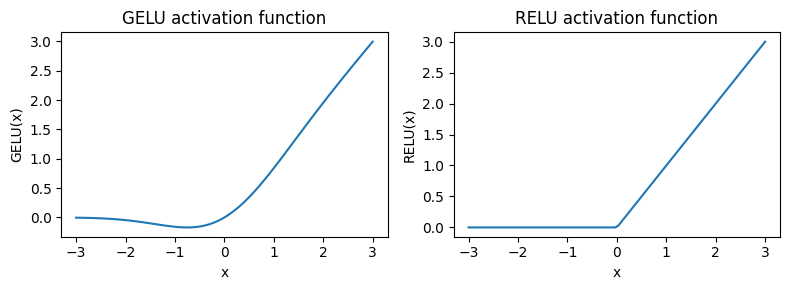

In [27]:
# GELU compared to RELU
import matplotlib.pyplot as plt

gelu, relu = GELU(), torch.nn.ReLU()

x = torch.linspace(-3, 3, 100)

gelu_out = gelu(x)
relu_out = relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([gelu_out, relu_out], ["GELU","RELU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
plt.tight_layout()
plt.show()

# GELU is a smooth, non-linear function that is differentiable at almost any negative value (except ~ -0.75). 
# Better optimisation due to:
# 1. smoothness
# 2. differential for negative values so these can contribute to the gradients/optimisation process

In [28]:
# Feedforward with GELU
# Feedforward layers enable richer representations through expansion to higher dimensions 

class FeedForward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']), GELU(), torch.nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']))
    
    def forward(self, x):
        out = self.layers(x)
        return out

print(GPT_CONFIG_124M)

ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn((2, 3, 768))
out = ffn(x)




{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [29]:
# Skip connections
# Create an alternative path for the gradient flow by adding the output from layer to the output of a later layer 
# First applied in "residual" networks in computer vision
# Help with optimisation process as the addition of the input (e.g x) to the output from a layer increase the magnitude of the values
# Thus helps with the vanishing gradient problem

class DeepNeuralNetwork(torch.nn.Module):
    def __init__(self, layer_sizes, use_skip):
        super().__init__()
        self.use_skip = use_skip
        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()), torch.nn.Sequential(torch.nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()), torch.nn.Sequential(torch.nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()), torch.nn.Sequential(torch.nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()), torch.nn.Sequential(torch.nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())])
    
    def forward(self, x):
        for layer in self.layers:
            layer_out = layer(x)
            if self.use_skip and x.shape == layer_out.shape:
                x = layer_out + x
            else:
                x = layer_out
        return x
                

def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = torch.nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1.0, 0., -1]])
torch.manual_seed(123)
model_no_skip = DeepNeuralNetwork(layer_sizes, use_skip=False)
print("no skip")
print_gradients(model_no_skip, sample_input)

# torch.manual_seed(123)
print("skip")
model_skip = DeepNeuralNetwork(layer_sizes, use_skip=True)
print_gradients(model_skip, sample_input)


no skip
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031
skip
layers.0.0.weight has gradient mean of 0.0014432291500270367
layers.1.0.weight has gradient mean of 0.004846951924264431
layers.2.0.weight has gradient mean of 0.004138893447816372
layers.3.0.weight has gradient mean of 0.005915115587413311
layers.4.0.weight has gradient mean of 0.032659437507390976


In [30]:

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1.0, 0., -1]])
torch.manual_seed(123)
model_no_skip = DeepNeuralNetwork(layer_sizes, use_skip=False)
print("no skip")
print_gradients(model_no_skip, sample_input)

torch.manual_seed(123)
print("skip")
model_skip = DeepNeuralNetwork(layer_sizes, use_skip=True)
print_gradients(model_skip, sample_input)

no skip
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031
skip
layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [31]:
# Transformer implementation - combines all of the above

class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = torch.nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        shortcut = x
        # layer norm
        x = self.norm1(x)
        # multihead attn
        x = self.att(x)
        # dropout
        x = self.drop_shortcut(x)
        # skip connection
        x = x + shortcut
        shortcut = x
        # layer norm
        x = self.norm2(x)
        # feedforward
        x = self.ff(x)
        # dropout
        x = self.drop_shortcut(x)
        # skip connection
        x = x + shortcut
        return x


torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

# The preservation of shape throughout the transformer block
# architecture is not incidental but a crucial aspect of its
# design. This design enables its effective application across a
# wide range of sequence-to-sequence tasks, where each
# output vector directly corresponds to an input vector,
# maintaining a one-to-one relationship

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [32]:
# GPT Model
from torch import nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        #1
        pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
print(first_batch[0].shape)
out = model(first_batch[0])
print("Input batch:\n", first_batch[0])
print("\nOutput shape:", out.shape)
print(out)


torch.Size([2, 1024])
Input batch:
 tensor([[   40,   367,  2885,  ...,   691, 12226,   318],
        [  367,  2885,  1464,  ..., 12226,   318,   284]])

Output shape: torch.Size([2, 1024, 50257])
tensor([[[ 0.2562, -0.3821,  0.0168,  ...,  0.1241,  0.3700, -0.4123],
         [ 0.3712, -0.0552, -0.1222,  ..., -0.1626, -0.3147,  0.7626],
         [ 0.4765,  0.4493,  1.0511,  ...,  0.0385, -1.0540,  0.1297],
         ...,
         [-1.1330, -0.1784, -0.9763,  ...,  0.6992, -0.7267, -0.0701],
         [-0.2662, -1.3487, -0.6321,  ..., -0.1184, -0.6835,  1.0175],
         [ 0.0862, -0.1340, -0.7118,  ...,  0.2626, -0.3656, -0.5268]],

        [[-0.4119, -0.1673,  0.6608,  ...,  0.0640, -0.1031, -0.0795],
         [-0.4023,  0.5445,  0.8093,  ..., -0.0984, -0.4531,  0.6515],
         [ 0.7643,  0.6143, -0.1449,  ...,  0.6180,  0.0286, -0.6892],
         ...,
         [-0.0452, -1.1259, -0.8943,  ...,  0.2212, -0.2829,  0.0982],
         [-0.4905, -1.2221, -0.3150,  ...,  0.1936, -0.8729,  0

In [33]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

total_params_gpt2 = (
total_params - sum(p.numel()
for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}"
)

Total number of parameters: 163,009,536
Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])
Number of trainable parameters considering weight tying: 124,412,160


In [34]:
# exercise
# Calculate and compare the number of parameters that are
# contained in the feed forward module and those that are
# contained in the multi-head attention module.

feedforward_params = 0
attn_params = 0
for i in range(len(model.trf_blocks)):
    feedforward_params+= sum(p.numel() for p in model.trf_blocks[i].ff.parameters())
    attn_params += sum(p.numel() for p in model.trf_blocks[i].att.parameters())
print(f"feedfordward params {feedforward_params}, attn params {attn_params}")

feedfordward params 56669184, attn params 28320768


In [35]:
total_size_bytes = total_params * 4 # 4 bytes per float32 parameter
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [36]:
# exercise
# implement GPT2-large and count params

GPT_CONFIG_124M
GPT_CONFIG_L = {"vocab_size": 50257, "context_length": 1024, "emb_dim": 1280, "n_heads": 20, "n_layers": 36, "drop_rate": 0.1, "qkv_bias": False}

large_model = GPTModel(GPT_CONFIG_L)
large_params = sum(p.numel() for p in large_model.parameters())
large_size = (large_params * 4) / (1024*1024)
print(f"large params {large_params}")
print(f"large model size {large_size:.2f} MB")

total_size_bytes = large_params * 4 # 4 bytes per float32 parameter
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

large params 838220800
large model size 3197.56 MB
Total size of the model: 3197.56 MB


In [44]:
# generate text
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        # last "timestep"/token i.e model generated output vs context
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        # cat the predicted token to the context for the next iteration
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

start_context = "Hello I am"
encoded = tokenizer.encode(start_context)
print(encoded)
enc_input = torch.tensor(encoded).unsqueeze(0)
model.eval()
next_iter = generate_text_simple(model, enc_input, 10, GPT_CONFIG_124M['context_length'])
next_iter
decoded_text = tokenizer.decode(next_iter.squeeze(0).tolist())
decoded_text


[15496, 314, 716]


'Hello I am282 PATHimp WORstd barrageMu 2014440 inflammatory'

In [45]:
# Chapter 5
# Pretraining

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [46]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    #1
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Reagan zone amplify convenanimate fel sunk sheer Cherokeeの�


In [47]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Characters: 20479
Tokens: 5145


In [48]:

torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [49]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")

for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [50]:
def calc_loss_batch(train_batch, target_batch, model, device):
    train_batch = train_batch.to(device)
    target_batch = target_batch.to(device)
    preds = model(train_batch)
    # flatten converts preds [9, 2, 256] --> [18, 256]; target_batch [9, 2] --> [18]
    loss = torch.nn.functional.cross_entropy(preds.flatten(0, 1), target_batch.flatten(0))
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader)) 
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, 2)
    val_loss = calc_loss_loader(train_loader, model, device, 2)
print(f"train loss {train_loss:.2f}")
print(f"val loss {val_loss:.2f}")








train loss 10.98
val loss 11.00


In [51]:


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() 
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, "
                        f"Val loss {val_loss:.3f}"
                )
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)



Ep 1 (Step 000000): Train loss 9.871, Val loss 10.086
Ep 1 (Step 000005): Train loss 7.976, Val loss 8.304
Every effort moves you,.                                                
Ep 2 (Step 000010): Train loss 6.525, Val loss 7.041
Ep 2 (Step 000015): Train loss 5.790, Val loss 6.590
Every effort moves you, and, and, and, and the the the the the the the the the, and the, and the, and the the, and the the the the the and the the the the the, and the the the the the ",
Ep 3 (Step 000020): Train loss 5.238, Val loss 6.447
Ep 3 (Step 000025): Train loss 4.527, Val loss 6.331
Every effort moves you in the, and in the of the of the the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of
Ep 4 (Step 000030): Train loss 3.634, Val loss 6.236
Ep 4 (Step 000035): Train loss 3.266, Val loss 6.216
Every effort moves you know, and, and, and in the picture, and Mrs.  "I was, as--and it's the picture to have to have t

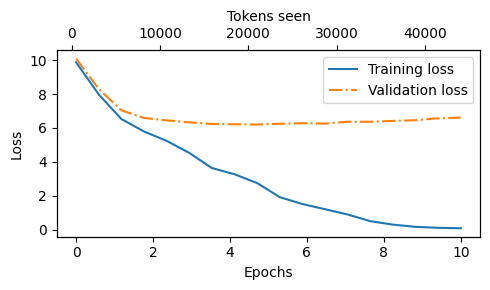

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    #1
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [53]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model, text_to_token_ids("every effort moves you", tokenizer), max_new_tokens=25, context_size=GPT_CONFIG_124M['context_length'])
text = token_ids_to_text(token_ids, tokenizer)
text


'every effort moves you?"\n"I didn\'t the by a smile that lifted the tips of a self-confident moustache, I'

In [47]:
# text generation methods to introduce variation in the outpt
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

# probabilistic sampling process using multinomial function
# multinomial function samples from the probas probability distribution num_samples times
# multinomial = probs distribution for discrete events, where each event takes on a fixed set of discrete possible values 
# in this case, possible outcomes = vocab 
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

forward
forward
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


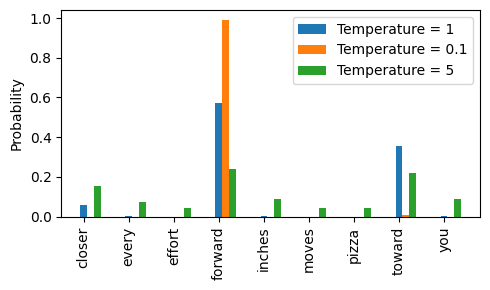

In [48]:
# temperature scaling = scale the softmax to control the width of the distribution
# dividing the logits with the temp values > 1, result in a flatter more spreadout distribution
# temp values < 1 result in a peakier distribution 
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
    bar_width, label=f'Temperature = {T}')
    ax.set_ylabel('Probability')
    ax.set_xticks(x)
    ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [49]:
# exercise 5.1 
#Use the print_sampled_tokens function to print the sampling
#frequencies of the softmax probabilities scaled with the
# temperatures shown in figure 5.14. How often is the word
# pizza sampled in each case? Can you think of a faster and
# more accurate way to determine how often the word pizza
# is sampled?

for T in temperatures:
    print(f"temp :{T}")
    scaled_probs = softmax_with_temperature(next_token_logits, T)
    print_sampled_tokens(scaled_probs)

# more efficient way
for T in temperatures:
    print(f"temp :{T}")
    scaled_probs = softmax_with_temperature(next_token_logits, T)
    sample = torch.multinomial(scaled_probs, num_samples=1000, replacement=True)#.item()

# pizza_sample = torch.sum(sample[])
pizza_sample = sum([x.item() for x in sample if x == 6])
pizza_sample

temp_scaled_probs = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
pizza_sample_temp_5 = temp_scaled_probs[2][6]
print(pizza_sample_temp_5)

temp :1
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
temp :0.1
0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
temp :5
165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you
temp :1
temp :0.1
temp :5
tensor(0.0430)


In [50]:
# topk sampling
# selects the top k scores from the logits and masks out the remaining possible token scores by replacing them with -inf 
# when applying softmax, those scores receive 0 probability and only the top k sampled words are considered for the output/generated token 
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

# derive new logits using where condition, by masking all values less than the n=k probability (last element) with -inf
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)

print(new_logits)
# get the probabilitis for the top k logits
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [81]:
# combine topk sampling with mulitnomial sampling and temperature scaling to generate text
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device),logits)
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


torch.manual_seed(123)
token_ids = generate(model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))





Output text:
 Every effort moves you in the Gisburn rather a little to live that point the tips of


In [52]:

# exercise 5.2
# different topk and temp settings - when is that desired?

temps = [1, 0.1, 5]
topk = [3, 10, 15]
settings_text = []
for t in temps:
    for k in topk:
        settings_text.append({"temp": t, "topk": k, "text": []})
# settings_text = [{"temp": t, "topk": k, "text": []} for t, k in zip(temps, topk)]

for i, set_ in enumerate(settings_text):
    token_ids = generate(model=model,
        idx=text_to_token_ids("Every effort moves you", tokenizer),
        max_new_tokens=15,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=25,
        temperature=1.4
    )
    # print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
    gen_text = token_ids_to_text(token_ids, tokenizer)
    settings_text[i]['text'] = gen_text

for set_ in settings_text:
    print(f"temp {set_['temp']}, topk {set_['topk']}, text {set_['text']}")

# EXERCISE 5.3
# What are the different combinations of settings for the
# generate function to force deterministic behavior, that is,
# disabling the random sampling such that it always
# produces the same outputs similar to the generate_simple
# function?
# temp = 0, topk = 1



temp 1, topk 3, text Every effort moves you?"

"Has he to hide to my--I turned, so
temp 1, topk 10, text Every effort moves you in the him, and pushed one of his painting; and the frame called
temp 1, topk 15, text Every effort moves you say her sp the tears I was taken nothing--I told Mrs. And
temp 0.1, topk 3, text Every effort moves you anagged him, me now, years the with the fact with equanim
temp 0.1, topk 10, text Every effort moves you everagged him, and pushed an to it were, so inevitably the picture
temp 0.1, topk 15, text Every effort moves you learned began to the-piece, in the table the fact on such my
temp 5, topk 3, text Every effort moves you?" The mere,-chair, as a smile thought fact should be interesting
temp 5, topk 10, text Every effort moves you just began to face was! She's a with a deprecating in
temp 5, topk 15, text Every effort moves you?"
" on painting people, as my own sex for my such's


In [53]:
# exercise 5.4 - save and load model weights and continue training for 1 epoch

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer_cor_keys.pth"
)

checkpoint = torch.load("model_and_optimizer_cor_keys.pth", map_location=device, weights_only=True)
new_model = GPTModel(GPT_CONFIG_124M)
new_model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(new_model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# model.train()



num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(
    new_model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=1, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)



Ep 1 (Step 000000): Train loss 0.043, Val loss 6.608
Ep 1 (Step 000001): Train loss 0.036, Val loss 6.622
Ep 1 (Step 000002): Train loss 0.036, Val loss 6.635
Ep 1 (Step 000003): Train loss 0.032, Val loss 6.645
Ep 1 (Step 000004): Train loss 0.020, Val loss 6.657
Ep 1 (Step 000005): Train loss 0.028, Val loss 6.668
Ep 1 (Step 000006): Train loss 0.026, Val loss 6.675
Ep 1 (Step 000007): Train loss 0.023, Val loss 6.678
Ep 1 (Step 000008): Train loss 0.020, Val loss 6.680
Every effort moves you know you know, and pushed one of the deep arm-chairs forward. "There: "Be dissatisfied with the fullest reassurance. Gisburn drew back his glory, he had dropped his painting.         


In [54]:
import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)


('gpt_download.py', <http.client.HTTPMessage at 0x52fecab60>)

In [37]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
model_size="124M", models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [39]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [53]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();






In [41]:

import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}", f"Right: {right.shape}"
    )
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
 

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [45]:

q_w, k_w, v_w = np.split((params["blocks"][0]["attn"]["c_attn"])["w"], 3, axis=-1)
print(q_w.T[:10])

gpt_weight_test = gpt.trf_blocks[0].att.W_query.weight

print(gpt_weight_test[:10])
assert torch.allclose(gpt_weight_test, torch.tensor(q_w.T))

[[-0.4738484   0.08742206  0.00388936 ... -0.25919554  0.15165617
  -0.41001597]
 [-0.26136586  0.1473427   0.06946629 ... -0.01636625  0.2170211
  -0.19235404]
 [-0.09780374  0.23870145  0.3668052  ...  0.19914557  0.10434178
  -0.2400296 ]
 ...
 [ 0.17441125  0.40739733 -0.13367423 ... -0.22591433 -0.11071706
  -0.21971957]
 [-0.18825532 -0.03070945  0.06061395 ...  0.05599799 -0.22653137
   0.38899696]
 [ 0.18357256  0.4110258   0.22059144 ...  0.12845424 -0.44823655
   0.41800687]]
tensor([[-0.4738,  0.0874,  0.0039,  ..., -0.2592,  0.1517, -0.4100],
        [-0.2614,  0.1473,  0.0695,  ..., -0.0164,  0.2170, -0.1924],
        [-0.0978,  0.2387,  0.3668,  ...,  0.1991,  0.1043, -0.2400],
        ...,
        [ 0.1744,  0.4074, -0.1337,  ..., -0.2259, -0.1107, -0.2197],
        [-0.1883, -0.0307,  0.0606,  ...,  0.0560, -0.2265,  0.3890],
        [ 0.1836,  0.4110,  0.2206,  ...,  0.1285, -0.4482,  0.4180]],
       grad_fn=<SliceBackward0>)


In [52]:

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    #1
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        # last "timestep"/token i.e model generated output vs context
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        # cat the predicted token to the context for the next iteration
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None, device="cpu"):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device),logits)
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_gpt = GPTModel(NEW_CONFIG)
load_weights_into_gpt(new_gpt, params)
new_gpt.to(device)
token_ids = generate(
    model=new_gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5,
    device=device
)
print("generate")
print(token_ids[:5])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

start_context = "Every effort moves you"
encoded = tokenizer.encode(start_context)
enc_input = torch.tensor(encoded).unsqueeze(0)
new_gpt.eval()
print("generate text simple")
out = generate_text_simple(model=new_gpt, idx=enc_input, max_new_tokens=25, context_size=NEW_CONFIG['context_length'])
text_out = token_ids_to_text(out, tokenizer=tokenizer)
print(text_out)


generate
tensor([[6109, 3626, 6100,  345,  257,  649,  367,   11,   39,   13,  554, 3919,
          287,  257, 1917,  287,  465, 2761,  326, 1281,  338,   12, 1558,    8,
          379, 1115,  517,  373,   62]])
Output text:
 Every effort moves you a new H,H. Inno in a problem in his problems that post's-17) at three more was_
generate text simple
Every effort moves you are the Jungle, I to the smell like a man's the year after the great, if the next was a new year


In [64]:

torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader
train_loss = calc_loss_loader(train_loader, gpt, device)
val_loss = calc_loss_loader(val_loader, gpt, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 8.154706372155083
Validation loss: 7.950900077819824


In [65]:
# exercise 5.5 
# calculate training and val losses with pretrained openai weights


num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 8.195, Val loss 7.951
Ep 1 (Step 000005): Train loss 8.194, Val loss 7.951
Every effort moves you are the Jungle, I to the smell like a man's the year after the great, if the next was a new year to the most likely to be a step by the new, of the U. It's of theodora is to-
Ep 2 (Step 000010): Train loss 8.303, Val loss 7.951
Ep 2 (Step 000015): Train loss 8.021, Val loss 7.951
Every effort moves you are the Jungle, I to the smell like a man's the year after the great, if the next was a new year to the most likely to be a step by the new, of the U. It's of theodora is to-
Ep 3 (Step 000020): Train loss 8.146, Val loss 7.951
Ep 3 (Step 000025): Train loss 8.164, Val loss 7.951
Every effort moves you are the Jungle, I to the smell like a man's the year after the great, if the next was a new year to the most likely to be a step by the new, of the U. It's of theodora is to-
Ep 4 (Step 000030): Train loss 8.168, Val loss 7.951
Ep 4 (Step 000035): Train loss 8.23

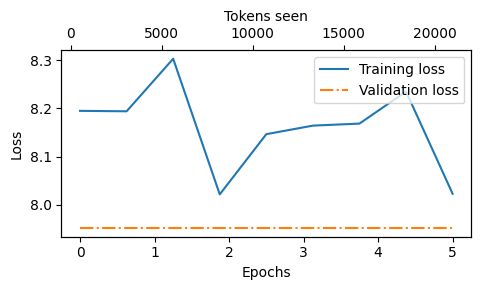

In [66]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


In [67]:
# chapter 6 - fine-tuning

import urllib.request
import zipfile
import os
from pathlib import Path
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
    "and extraction.")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [68]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [69]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [70]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())


Label
ham     747
spam    747
Name: count, dtype: int64


In [71]:
# balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df['Label'] = balanced_df['Label'].map({"ham": 0, "spam": 1})
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [72]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
print(train_df.shape[0], validation_df.shape[0], test_df.shape[0])
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)
train_df

1045 149 300


,Label,Text
0,0,Dude how do you like the buff wind.
1,0,Tessy..pls do me a favor. Pls convey my birthd...
2,1,Reminder: You have not downloaded the content ...
3,1,Got what it takes 2 take part in the WRC Rally...
4,1,"Shop till u Drop, IS IT YOU, either 10K, 5K, £..."
...,...,...
1040,1,4mths half price Orange line rental & latest c...
1041,1,Thanks for the Vote. Now sing along with the s...
1042,1,IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX...
1043,1,Urgent! call 09066612661 from landline. Your c...


In [73]:
train_df = pd.read_csv("train.csv")
train_df

,Label,Text
0,0,Dude how do you like the buff wind.
1,0,Tessy..pls do me a favor. Pls convey my birthd...
2,1,Reminder: You have not downloaded the content ...
3,1,Got what it takes 2 take part in the WRC Rally...
4,1,"Shop till u Drop, IS IT YOU, either 10K, 5K, £..."
...,...,...
1040,1,4mths half price Orange line rental & latest c...
1041,1,Thanks for the Vote. Now sing along with the s...
1042,1,IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX...
1043,1,Urgent! call 09066612661 from landline. Your c...


In [74]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data['Text']]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        self.encoded_texts = [encoded_text + [pad_token]*(self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts]
        
    def __getitem__(self, idx):
        encoded = self.encoded_texts[idx]
        label = self.data.iloc[idx]['Label']
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_len = 0
        for seq in self.encoded_texts:
            if len(seq) > max_len:
                max_len = len(seq)
        return max_len

tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", tokenizer)

print(train_dataset.max_length)

# use train datasets max_length for val and test
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)


120


In [75]:
# exercise 6.1

# Pad the inputs to the maximum number of tokens the
# model supports and observe how it affects the predictive
# performance

In [76]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


In [77]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
"vocab_size": 50257,
"context_length": 1024,
"drop_rate": 0.0,
"qkv_bias": True
}
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


In [78]:
from gpt_download import download_and_load_gpt2
# from book_code.ch05 import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [ ]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you are the Jungle, I to the smell like a man's the year after


In [ ]:
text_2 = (
"Is the following text 'spam'? Answer with 'yes' or 'no':"
" 'You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'
















- (Gone of the


In [82]:
# freeze model layers
# replace last layer with classifier layer consisting of two heads - 1 for spam and 1 for not-spam 
# only need to fine-tune the last (few) layers of the network 
torch.manual_seed(123)
for param in model.parameters():
    param.requires_grad = False

# output layer hs requires_grad set to True by default
num_classes = 2
model.out_head = nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=num_classes)

# unfreeze last transform block and layernorm layer

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True


In [88]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

with torch.no_grad():
    outputs = model(inputs)
# output dim is now 2 instead of vocab_size 
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

# Given the causal attention mask setup in figure 6.12, the
# last token in a sequence accumulates the most information
# since it is the only token with access to data from all the
# previous tokens. Therefore, in our spam classification task,
# we focus on this last token during the fine-tuning process
# use last output token to generate prediction
# this token has seen all the context from the previous tokens 
print("Last output token:", outputs[:, -1, :])

probs = torch.softmax(outputs[:, -1, :], dim=-1)
pred = torch.argmax(probs)
print(pred)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-0.3194,  0.0427],
         [-3.0345,  0.6616],
         [-0.3902,  0.3803],
         [-0.6379,  1.5290]]])
Outputs dimensions: torch.Size([1, 4, 2])
Last output token: tensor([[-0.6379,  1.5290]])
tensor(1)


In [90]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            # largest values will already correspond to the token with the highest probability so we can skip the softmax function
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += ((predicted_labels == target_batch).sum().item())
        else:
            break
    return correct_predictions / num_examples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
acc = calc_accuracy_loader(train_loader, model, device, num_batches=10)
print(acc)

0.3375


In [91]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
            input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

with torch.no_grad():
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.275
Validation loss: 3.194
Test loss: 2.630


In [92]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss


def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], [] #1
    examples_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                f"Train loss {train_loss:.3f}, "
                f"Val loss {val_loss:.3f}"
                )
        train_accuracy = calc_accuracy_loader(
        train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
        val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen




In [93]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50,
    eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.125, Val loss 3.027
Ep 1 (Step 000050): Train loss 0.334, Val loss 0.604
Ep 1 (Step 000100): Train loss 0.338, Val loss 0.443
Training accuracy: 85.00% | Validation accuracy: 80.00%
Ep 2 (Step 000150): Train loss 0.520, Val loss 0.347
Ep 2 (Step 000200): Train loss 0.376, Val loss 0.338
Ep 2 (Step 000250): Train loss 0.410, Val loss 0.318
Training accuracy: 80.00% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.362, Val loss 0.293
Ep 3 (Step 000350): Train loss 0.328, Val loss 0.280
Training accuracy: 90.00% | Validation accuracy: 85.00%
Ep 4 (Step 000400): Train loss 0.180, Val loss 0.306
Ep 4 (Step 000450): Train loss 0.297, Val loss 0.262
Ep 4 (Step 000500): Train loss 0.257, Val loss 0.276
Training accuracy: 90.00% | Validation accuracy: 87.50%
Ep 5 (Step 000550): Train loss 0.202, Val loss 0.233
Ep 5 (Step 000600): Train loss 0.293, Val loss 0.244
Training accuracy: 95.00% | Validation accuracy: 90.00%
Training completed in 4.76 minu

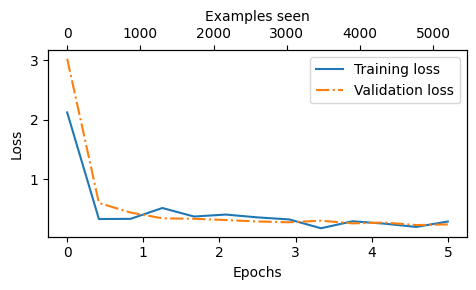

In [94]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    #1
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    #4
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

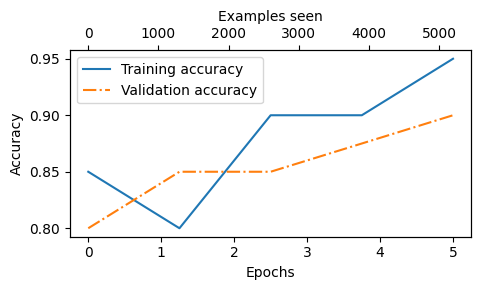

Training accuracy: 90.10%
Validation accuracy: 88.59%
Test accuracy: 87.67%


In [96]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(
epochs_tensor, examples_seen_tensor, train_accs, val_accs,
label="accuracy"
)
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

In [100]:
def classify_review(text, model, tokenizer, device, max_length=None,pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    print(f"predicted label {predicted_label}")
    return "spam" if predicted_label == 1 else "not spam"

text_1 = (
"You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

text_2 = (
"Hey, just wanted to check if we're still on"
" for dinner tonight? Let me know!"
)
print(classify_review(
text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

predicted label 0
not spam
predicted label 0
not spam


Ep 1 (Step 000000): Train loss 0.941, Val loss 1.122
Ep 1 (Step 000050): Train loss 0.978, Val loss 1.122
Ep 1 (Step 000100): Train loss 0.940, Val loss 1.122
Training accuracy: 47.50% | Validation accuracy: 52.50%
Ep 2 (Step 000150): Train loss 1.071, Val loss 1.122
Ep 2 (Step 000200): Train loss 1.433, Val loss 1.122
Ep 2 (Step 000250): Train loss 0.709, Val loss 1.122
Training accuracy: 52.50% | Validation accuracy: 52.50%
Ep 3 (Step 000300): Train loss 0.920, Val loss 1.122
Ep 3 (Step 000350): Train loss 1.126, Val loss 1.122
Training accuracy: 57.50% | Validation accuracy: 52.50%
Ep 4 (Step 000400): Train loss 0.519, Val loss 1.122
Ep 4 (Step 000450): Train loss 1.155, Val loss 1.122
Ep 4 (Step 000500): Train loss 0.937, Val loss 1.122
Training accuracy: 55.00% | Validation accuracy: 52.50%
Ep 5 (Step 000550): Train loss 1.020, Val loss 1.122
Ep 5 (Step 000600): Train loss 1.272, Val loss 1.122
Training accuracy: 52.50% | Validation accuracy: 52.50%
Training completed in 8.35 minu

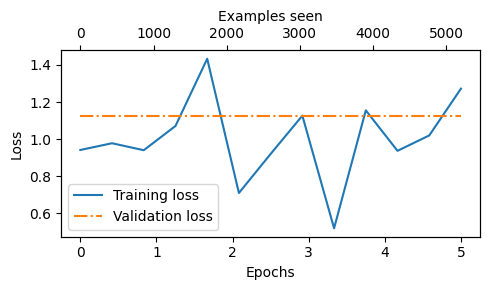

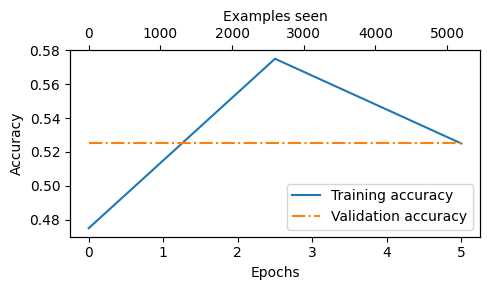

Training accuracy: 50.58%
Validation accuracy: 55.03%
Test accuracy: 51.33%


In [ ]:
# EXERCISE 6.2 FINE-TUNING THE WHOLE MODEL
# Instead of fine-tuning just the final transformer block,
# fine-tune the entire model and assess the effect on
# predictive performance

torch.manual_seed(123)

new_model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(new_model, params)
# for param in model.parameters():
#     param.requires_grad = False

# output layer hs requires_grad set to True by default
num_classes = 2
new_model.out_head = nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=num_classes)

# unfreeze last transform block and layernorm layer

# for param in model.trf_blocks[-1].parameters():
#     param.requires_grad = True
# for param in model.final_norm.parameters():
#     param.requires_grad = True

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    new_model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50,
    eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)


epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(
epochs_tensor, examples_seen_tensor, train_accs, val_accs,
label="accuracy"
)
train_accuracy = calc_accuracy_loader(train_loader, new_model, device)
val_accuracy = calc_accuracy_loader(val_loader, new_model, device)
test_accuracy = calc_accuracy_loader(test_loader, new_model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

In [54]:
# EXERCISE 6.3 FINE-TUNING THE FIRST VS. LAST TOKEN
# Try fine-tuning the first output token. Notice the changes
# in predictive performance compared to fine-tuning the last
# output token.

In [55]:

# chapter 6 - fine-tuning

import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
    "and extraction.")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [56]:

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import tiktoken
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data['Text']]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        self.encoded_texts = [encoded_text + [pad_token]*(self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts]
        
    def __getitem__(self, idx):
        encoded = self.encoded_texts[idx]
        label = self.data.iloc[idx]['Label']
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_len = 0
        for seq in self.encoded_texts:
            if len(seq) > max_len:
                max_len = len(seq)
        return max_len

tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", tokenizer)

print(train_dataset.max_length)

# use train datasets max_length for val and test
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)


num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

120
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


In [57]:

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
"vocab_size": 50257,
"context_length": 1024,
"drop_rate": 0.0,
"qkv_bias": True
}
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


In [58]:
from gpt_implementation import GPTModel
from gpt_implementation import load_weights_into_gpt
from gpt_implementation import generate, text_to_token_ids, token_ids_to_text
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

# from book_code.ch05 import GPTModel, load_weights_into_gpt

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
"vocab_size": 50257,
"context_length": 1024,
"drop_rate": 0.0,
"qkv_bias": True
}
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"],
    top_k=50,
    temperature=1.5,
    device=device
)
print("generate")
print(token_ids[:5])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
generate
tensor([[6109, 3626, 6100,  345,  832,  257,  890, 1351,   13, 1400, 3626,  460,
  

In [60]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        #1
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
"https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
"/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [66]:
data[:5]

[{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
  'input': 'freind --> friend',
  'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'},
 {'instruction': 'Edit the following sentence for grammar.',
  'input': 'He go to the park every day.',
  'output': 'He goes to the park every day.'},
 {'instruction': 'Convert 45 kilometers to meters.',
  'input': '',
  'output': '45 kilometers is 45000 meters.'},
 {'instruction': "Rewrite this sentence to start with 'Although': Despite the rain, they went for a walk.",
  'input': '',
  'output': 'Although it was raining, they went for a walk.'},
 {'instruction': 'What are the first 10 square numbers?',
  'input': '',
  'output': '1, 4, 9, 16, 25, 36, 49, 64, 81, 100.'}]

In [70]:
def format_input(entry):
    instruction_text = (
    f"Below is an instruction that describes a task. "
    f"Write a response that appropriately completes the request."
    f"\n\\n### Instruction:\\n{entry['instruction']}"
    )
    input_text = (
    f"\n\\n### Input:\\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

model_input = format_input(data[50])
desired_response = f"\n\\n### Response:\\n{data[50]['output']}"
print(model_input + desired_response)

model_input = format_input(data[999])
desired_response = f"\n\\n### Response:\\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.
\n### Instruction:\nIdentify the correct spelling of the following word.
\n### Input:\nOcassion
\n### Response:\nThe correct spelling is 'Occasion.'
Below is an instruction that describes a task. Write a response that appropriately completes the request.
\n### Instruction:\nWhat is an antonym of 'complicated'?
\n### Response:\nAn antonym of 'complicated' is 'simple'.


In [72]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [ ]:
import torch
from torch.utils.data import Dataset
import tiktoken

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\\n### Response:\\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

# collate fn is responsible for taking a list of individual samples and creating a batch that can be processed efficiently

def custom_collate_draft_1(
        batch,
        pad_token_id=50256,
        device="cpu"
    ):
    batch_max_length = max(len(item)+1 for item in batch) #1
    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor



In [ ]:
# EXERCISE 7.1 CHANGING PROMPT STYLES
# After fine-tuning the model with the Alpaca prompt style,
# try the Phi-3 prompt style shown in figure 7.4 and observe
# whether it affects the response quality of the model.